# 05: Evolving Spatial Fields

Although it is often enough to work with one-dimensional time series, sometimes we want to be able to visualize the evolution (or co-evolution) of time-varying spatial distributions. This fifth stage of the tutorial demonstrates how to construct spatial distributions of trends, spatial distributions of correlations with one-dimensional time series, and regressions onto one-dimensional time series. These examples also demonstrate ways to link xarray objects from different sources for analysis.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.util as cputil
import colormaps

Read in data. Here we use the sea surface temperatures again.

In [2]:
sst = xr.open_dataset('./data/sst_cobe2.1x1.1850-2024.1m.nc')['sst']

---
### Trends

The following function wraps [scipy.stats.linregress()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) for easier use with xarray DataArray objects.

In [3]:
def regress(x, y): 
    if np.isnan(y).all():
        return np.nan, np.nan, np.nan, np.nan, np.nan
    else: 
        return linregress(x, y)

We select the period after 1950 when observations are [more reliable](https://doi.org/10.1002/2013RG000434). Trends are also larger after 1950, as shown in [part 4](04-WeightsAndRolls.ipynb) of these tutorials. The mean seasonal cycle over 1950-2024 is subtracted to compute anomalies. We then select annual mean anomalies for the January-March and July-September seasons.

In [4]:
# Trends over 1950-2024
sstpd = sst.sel(time=slice('1950', '2024'))
sst_anm = sstpd.groupby('time.month') - sstpd.groupby('time.month').mean('time')

# SST seasonal cycle delayed relative to land (JFM and JAS)
sst_jfm = sstpd.sel(time=sst_anm.time.dt.month.isin([1,2,3])).groupby('time.year').mean('time')
sst_jas = sstpd.sel(time=sst_anm.time.dt.month.isin([7,8,9])).groupby('time.year').mean('time')

# Create a dummy index to use for calculating the trend
times = xr.DataArray(np.arange(75), coords={'year': sst_jfm.year}, dims=['year'])

For convenience and readability, it is often useful to use the [xarray.apply_ufunc()](https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html) interface to apply functions along a given dimension. You can define the function yourself or use functions from numpy, scipy, or other modules compatible with xarray. The result contains the standard outputs of [scipy.stats.linregress()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) (slope, intercept, Pearson's correlation coefficient, *p* value, and standard error of the slope) at all grid locations. Each of these return values is a DataArray with dimensions of latitude and longitude.
- [A gentle introduction to apply_ufunc](https://tutorial.xarray.dev/advanced/apply_ufunc/simple_numpy_apply_ufunc.html)

In [5]:
# Summer and winter trends, 1950-2024
rgr_jfm = xr.apply_ufunc(regress, times, sst_jfm, input_core_dims=[['year'], ['year']],
                         output_core_dims=[[], [], [], [], []], vectorize=True)
rgr_jas = xr.apply_ufunc(regress, times, sst_jas, input_core_dims=[['year'], ['year']],
                         output_core_dims=[[], [], [], [], []], vectorize=True)

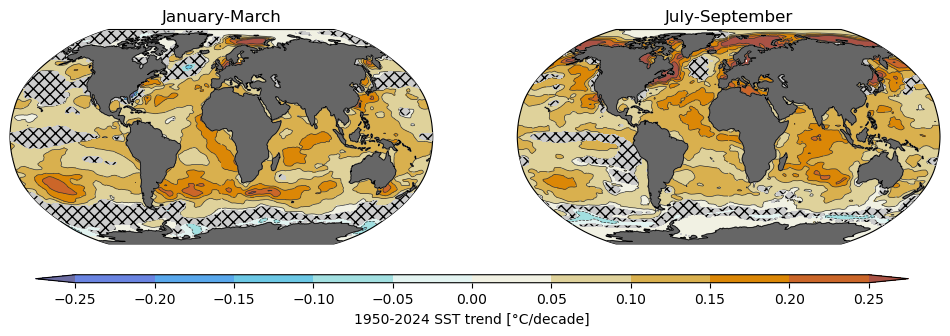

In [6]:
pv = 0.05

# Make the plot
fig = plt.figure(figsize=(12,4))   
axa = fig.add_subplot(121, projection=ccrs.Robinson())
axb = fig.add_subplot(122, projection=ccrs.Robinson())
clrs = colormaps.prinsenvlag_r

# Levels and contour lines (same for all panels)
dlv = [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]
llv = [-0.25, -0.2, -0.15, -0.1, -0.05, 0.05, 0.1, 0.15, 0.2, 0.25]
lls = ['--', '--', '--', '--', '--', '-', '-', '-', '-', '-']

# Plotting parameters
cax = fig.add_axes([0.11, 0.13, 0.8, 0.02]) # In this case, with multiple plots, we define an axis for the shared colorbar
cbkws = {'label': '1950-2024 SST trend [°C/decade]', 'orientation': 'horizontal', 'ticks': dlv}
kwrgs = {'cmap': clrs, 'levels': dlv, 'extend': 'both', 'transform': ccrs.PlateCarree(), 'cbar_ax': cax, 'cbar_kwargs': cbkws}
lwrgs = {'levels': llv, 'colors': ['#333'], 'transform': ccrs.PlateCarree(), 'linestyles': lls, 'linewidths': [0.5]}

# Plot the data for p value < 0.01
(10*rgr_jfm[0]).plot(ax=axa, **kwrgs)
(10*rgr_jfm[0]).plot.contour(ax=axa, **lwrgs)
rgr_jfm[3].plot.contourf(ax=axa, hatches=['xxx'], levels=[pv, 1], colors=['#ccc'], extend='neither', add_colorbar=False, 
                         transform=ccrs.PlateCarree(), zorder=4)
(10*rgr_jas[0]).plot(ax=axb, **kwrgs)
(10*rgr_jas[0]).plot.contour(ax=axb, **lwrgs)
rgr_jas[3].plot.contourf(ax=axb, hatches=['xxx'], levels=[pv, 1], colors=['#ccc'], extend='neither', add_colorbar=False, 
                         transform=ccrs.PlateCarree(), zorder=4)

# Clean up
for ax in [axa, axb]: 
    ax.add_feature(cfeat.LAND, color='#666', zorder=5)
    ax.add_feature(cfeat.COASTLINE, linewidth=0.5, zorder=8)

axa.set_title('January-March')
axb.set_title('July-September')

plt.show()

Here we have used the *p*-value DataArray returned from the regress() function to mask areas with *p* ≥ pv, which we set to 0.05 in the first line of the block. Filled contours can be hatched as shown in the example. Trends in deseasonalized sea surface temperature anomalies are larger in the summer hemisphere.

---
### Correlation

In this section, we demonstrate how to construct a map of correlations between a geospatial field and a one-dimensional time series. The SST fields from the previous example are combined with the [All India Summer Monsoon Rainfall (AISMR)](https://mol.tropmet.res.in/monsoon-interannual-timeseries/) index for the period 1871-2019. 

First we read in the AISMR time series, which is contained in a text file. There are many ways to access such files in python. Here we read the file and convert the content to DataArray objects by using [pandas.read_csv()](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) and the [pandas.DataFrame.to_xarray()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_xarray.html) method. 

In [7]:
# Covers 1871-2019
aismr = pd.read_csv('./data/iitm_aismr.txt', header=3, sep='\t', index_col=0).to_xarray()
# Clean up the names and dimensions of the resulting DataArray
aismr = aismr.rename({'Rainfall % Departure': 'rainfall', 'Year': 'year'})['rainfall']

We compute correlation distributions for the preceding winter (January-March), the preceding spring (April-June), and the simultaneous summer (July-September). For readability, we might select sea surface temperatures for the overlapping period; however, xarray automatically aligns the objects along the common "year" axis. Small differences in the results are due to differences in the polynomial fit used to detrend the data.

In [8]:
# Select JJAS SST anomalies for years 1871-2019
# sst = sst.sel(time=slice('1871','2019'))
sst_jfm = sst.sel(time=sst.time.dt.month.isin([1,2,3])).groupby('time.year').mean('time')
sst_amj = sst.sel(time=sst.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time')
sst_jas = sst.sel(time=sst.time.dt.month.isin([7,8,9])).groupby('time.year').mean('time')

SST is subject to large trends (see [part 4](04-WeightsAndRolls.ipynb)) but there is relatively little trend in the AISMR (consider checking this as an exercise). However, from part 4, we have seen that the trend is not strictly linear. Here, we remove the long-term trend in SST as a fourth-order polynomial fit, consistent with the early twentieth-century rise in temperature, the mid-century dip, and the sharp increase after 1980. The [xarray.DataArray.polyfit()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.polyfit.html) method provides a convenient way to do this.

In [9]:
def trend(da, dim='time', deg=1):
    # calculate the trend along a single dimension
    p = da.polyfit(dim=dim, deg=deg) # least squares fit for a polynomial of degree deg
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return fit

In [10]:
# Detrend SSTs
sst_jfm = sst_jfm - trend(sst_jfm, dim='year', deg=4)
sst_amj = sst_amj - trend(sst_amj, dim='year', deg=4)
sst_jas = sst_jas - trend(sst_jas, dim='year', deg=4)

It is then straightforward to compute the correlation distributions using [xarray.corr()](https://docs.xarray.dev/en/stable/generated/xarray.corr.html) along the common "year" dimension.

In [11]:
jfm_crr = xr.corr(sst_jfm, aismr, dim='year')
amj_crr = xr.corr(sst_amj, aismr, dim='year')
jas_crr = xr.corr(sst_jas, aismr, dim='year')

Finally, we plot the series of correlation maps as a multi-panel figure.

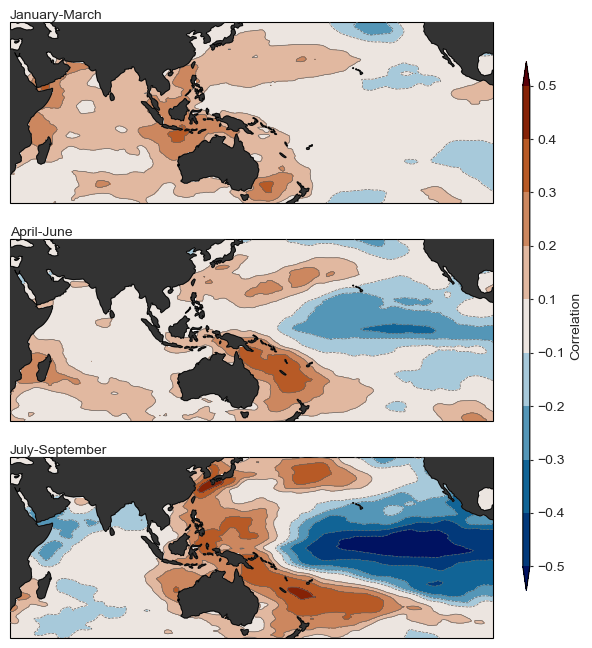

In [12]:
sns.set_style('white', {"axes.edgecolor": "k"})

# contour levels
clv = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5]
lls = ['--']*5 + ['-']*5

# Set figure style
proj = ccrs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(7,8))   
axa = fig.add_subplot(311, projection=proj)
axb = fig.add_subplot(312, projection=proj)
axc = fig.add_subplot(313, projection=proj)

cbx = fig.add_axes([0.9, 0.1, 0.01, 0.8]) # In this case, with multiple plots, we define an axis for the shared colorbar
cbkws = {'label': 'Correlation', 'orientation': 'vertical', 'ticks': clv}
kwrgs = {'cmap': colormaps.vik, 'levels': clv, 'extend': 'both', 'transform': ccrs.PlateCarree(), 'cbar_ax': cbx, 'cbar_kwargs': cbkws}
lwrgs = {'levels': clv, 'colors': ['#666666'], 'transform': ccrs.PlateCarree(), 'linestyles': lls, 'linewidths': [0.5], 'zorder': 5}

jfm_crr.plot.contourf(ax=axa, **kwrgs)
jfm_crr.plot.contour(ax=axa, **lwrgs)
amj_crr.plot.contourf(ax=axb, **kwrgs)
amj_crr.plot.contour(ax=axb, **lwrgs)
jas_crr.plot.contourf(ax=axc, **kwrgs)
jas_crr.plot.contour(ax=axc, **lwrgs)

axa.text(0, 1, 'January-March', ha='left', va='bottom', transform=axa.transAxes)
axb.text(0, 1, 'April-June', ha='left', va='bottom', transform=axb.transAxes)
axc.text(0, 1, 'July-September', ha='left', va='bottom', transform=axc.transAxes)
cbx.tick_params(length=2, which='both')

for ax in [axa, axb, axc]:
    ax.add_feature(cfeat.LAND, color='#333', zorder=10)
    ax.add_feature(cfeat.COASTLINE, linewidth=0.5, zorder=12)
    ax.set_extent([-150, 90, -45, 45], crs=proj)

These results illustrate how strong monsoon years in South Asia typically follow warmer sea surface temperatures in the Indian Ocean, but leave the upwelling zone along the Somali coast and the Arabian Sea cooler than normal. Conversely, weak monsoon years tend to co-occur with developing El Niño events.